In [38]:
import pandas as pd

data = pd.read_csv("Salary_Data.csv")
data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [39]:
data = data.dropna(subset=["Years of Experience"])
data = data.dropna(subset=["Salary"])
data = data.dropna(subset=["Education Level"])

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6698 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6698 non-null   float64
 1   Gender               6698 non-null   object 
 2   Education Level      6698 non-null   object 
 3   Job Title            6698 non-null   object 
 4   Years of Experience  6698 non-null   float64
 5   Salary               6698 non-null   float64
dtypes: float64(3), object(3)
memory usage: 366.3+ KB


In [41]:
data[["Education Level", "Job Title"]].value_counts()

Education Level    Job Title                
PhD                Data Scientist               330
                   Software Engineer Manager    270
Bachelor's         Data Analyst                 259
Bachelor's Degree  Software Engineer            251
Bachelor's         Software Engineer            227
                                               ... 
PhD                Principal Engineer             1
                   Senior Researcher              1
Bachelor's         Accountant                     1
                   Account Manager                1
phD                Marketing Coordinator          1
Name: count, Length: 313, dtype: int64

In [42]:
data.describe()

,Age,Years of Experience,Salary
count,6698.000000,6698.000000,6698.000000
mean,33.623022,8.095178,115329.253061
std,7.615784,6.060291,52789.792507
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


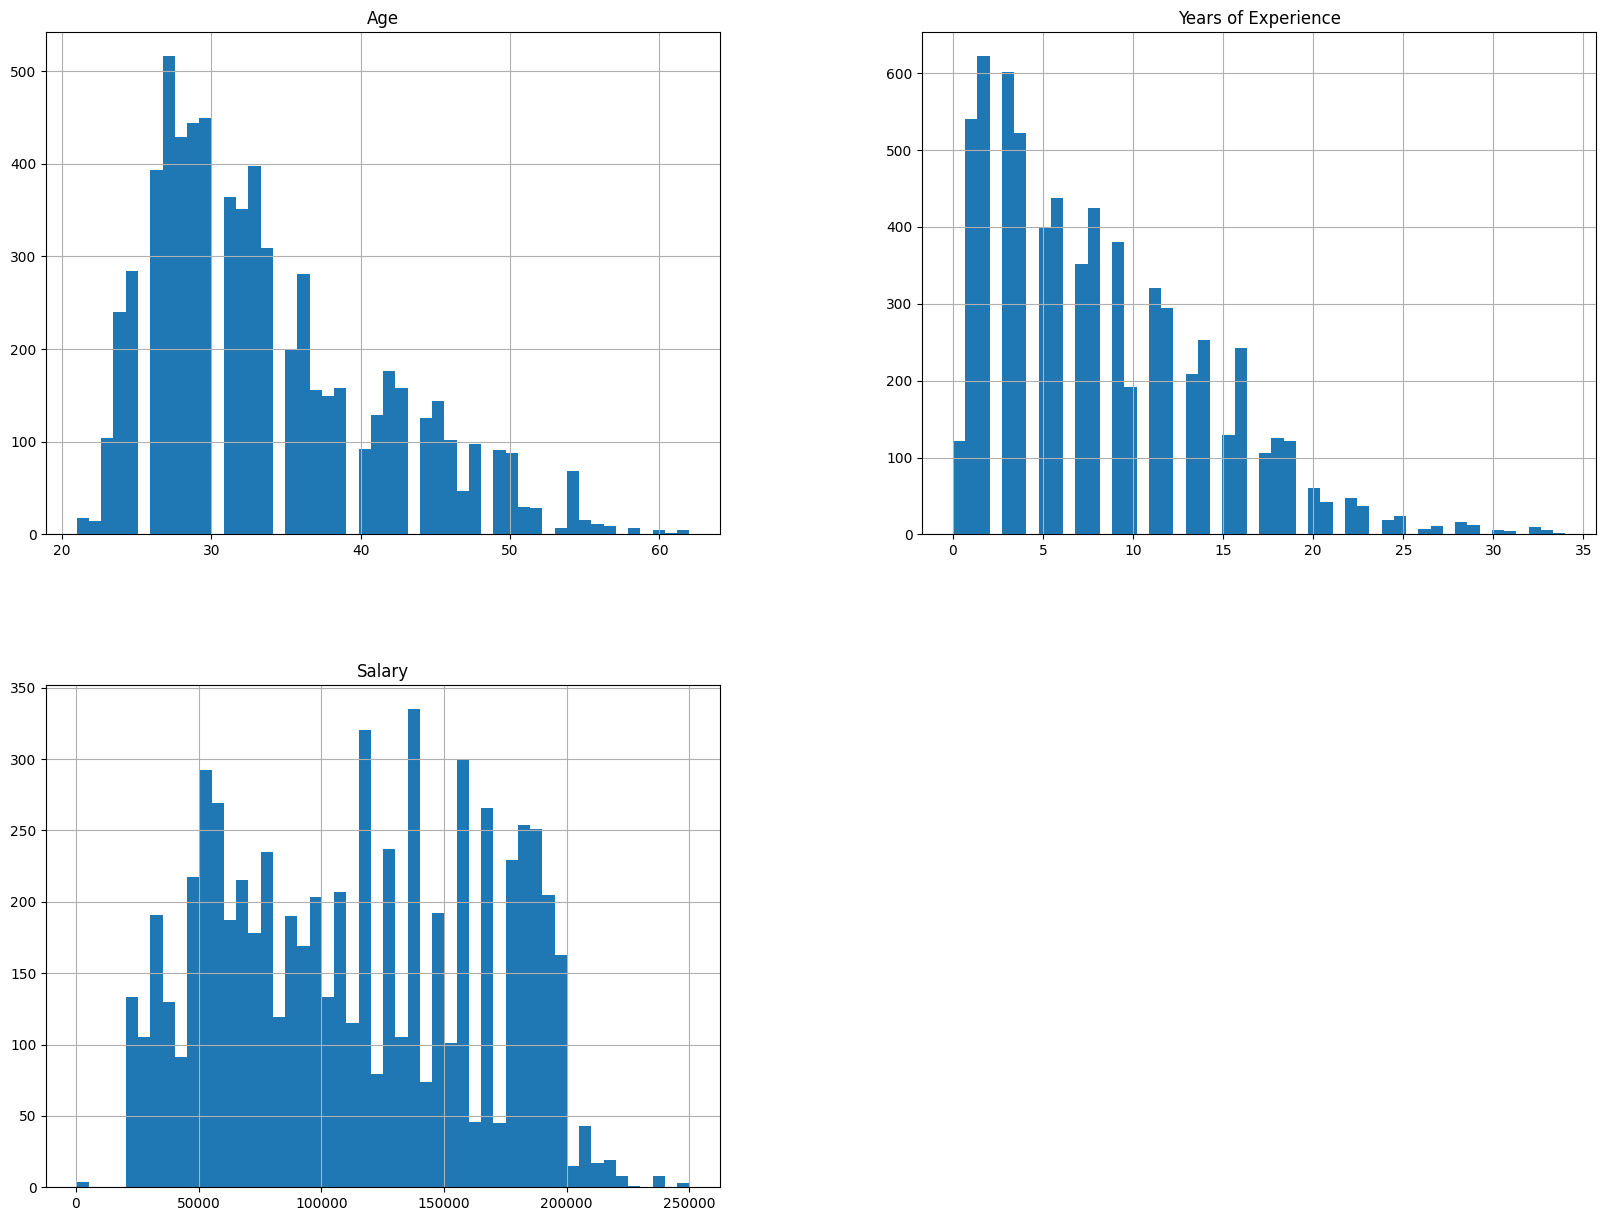

In [43]:
import matplotlib.pyplot as plt

data.hist(bins=50, figsize=(20, 15))
plt.show()

In [44]:
import numpy as np
def split_train_test(X, test_ratio):
    shuffled_indices = np.random.permutation(len(X))
    test_length = int(len(X) * test_ratio)
    train_indices = shuffled_indices[:test_length]
    test_indices = shuffled_indices[test_length:]

    return data.iloc[train_indices], data.iloc[test_indices]

test_set, train_set = split_train_test(data, 0.2)
print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 5359, Test set size: 1339


In [45]:
from zlib import crc32
def is_id_in_test_set(identifier, test_size):
    return crc32(np.int64(identifier)) < test_size * 2**32

def split_data_with_hash_id(data, test_size, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda x: is_id_in_test_set(x, test_size))

    return data.loc[~in_test_set], data.loc[in_test_set]

data_with_id = data.reset_index()

train_set, test_set = split_data_with_hash_id(data_with_id, 0.2, "index")
print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 5357, Test set size: 1341


In [46]:
data_with_id["uid"] = data_with_id["Age"] * 1000 + data_with_id["Years of Experience"]
train_set, test_set = split_data_with_hash_id(data_with_id, 0.2, "uid")

In [47]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [48]:
data["exp_cat"] = pd.cut(data["Years of Experience"],
                         bins = [5, 10, 15, 20, 25, np.inf],
                         labels = [1, 2, 3, 4, 5]
)

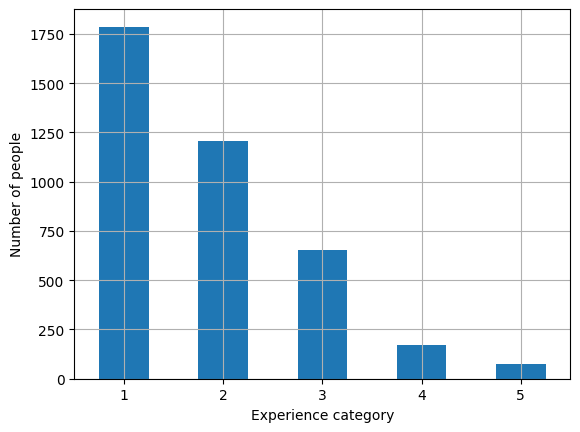

In [49]:
data["exp_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Experience category")
plt.ylabel("Number of people")
plt.show()

In [50]:
data = data.dropna(subset=["exp_cat"])

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits=[]

for train_size, test_size in splitter.split(data, data["exp_cat"]):
    train_set_n = data.iloc[train_size]
    test_set_n = data.iloc[test_size]

    strat_splits.append((train_set_n, test_set_n))

In [52]:
strat_train_set, strat_test_set = train_test_split(data, test_size=0.2,
                                                   stratify=data["exp_cat"], random_state=42)

In [53]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("exp_cat", axis=1, inplace=True)

In [54]:
data = strat_train_set.copy()

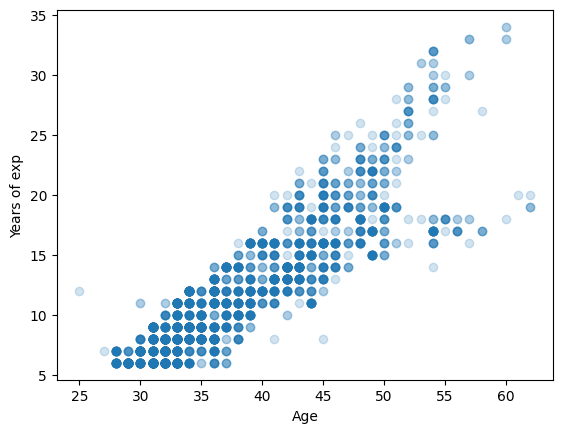

In [55]:
plt.scatter(data["Age"], data["Years of Experience"], alpha=0.2)
plt.xlabel("Age")
plt.ylabel("Years of exp")
plt.show()

In [56]:
numeric_data = data.select_dtypes(include=["number"])
corr_matrix = numeric_data.corr()

In [57]:
corr_matrix["Salary"].sort_values(ascending=False)

Salary                 1.000000
Years of Experience    0.612501
Age                    0.504126
Name: Salary, dtype: float64

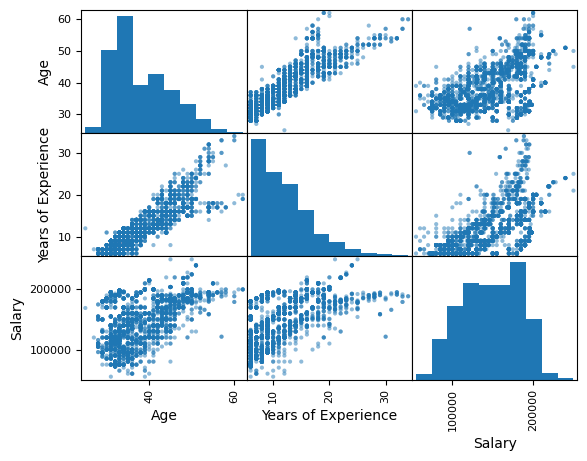

In [58]:
from pandas.plotting import scatter_matrix

scatter_matrix(numeric_data, grid=True)
plt.show()

In [59]:
data = strat_train_set.drop("Salary", axis=1)
data_labels = strat_train_set["Salary"].copy()

In [60]:
data_test = strat_test_set.drop("Salary", axis=1)
data__test_labels = strat_test_set["Salary"].copy()

In [61]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
data_num = data.select_dtypes(include=[np.number])
imputer.fit(data_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [62]:
print(imputer.statistics_)

[36. 11.]


In [63]:
X = imputer.transform(data_num)

In [64]:
data_tr = pd.DataFrame(X, columns=data_num.columns,
                       index=data.index)

In [65]:
from sklearn.preprocessing import OneHotEncoder

data_cat = data[["Gender", "Job Title", "Education Level"]]

cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(data_cat)

In [66]:
data_test_cat_1hot = cat_encoder.transform(data_cat)

In [67]:
cat_encoder.categories_

[array(['Female', 'Male', 'Other'], dtype=object),
 array(['Administrative Assistant', 'Back end Developer',
        'Business Intelligence Analyst', 'CEO', 'Chief Data Officer',
        'Content Marketing Manager', 'Customer Service Manager',
        'Data Analyst', 'Data Scientist', 'Digital Marketing Manager',
        'Director of Business Development', 'Director of Data Science',
        'Director of Engineering', 'Director of Finance', 'Director of HR',
        'Director of Human Capital', 'Director of Human Resources',
        'Director of Marketing', 'Director of Operations',
        'Director of Product Management', 'Director of Sales',
        'Event Coordinator', 'Financial Advisor', 'Financial Analyst',
        'Financial Manager', 'Front end Developer', 'Full Stack Engineer',
        'HR Generalist', 'HR Manager', 'Human Resources Director',
        'Human Resources Manager', 'IT Manager', 'IT Support Specialist',
        'Junior Data Analyst', 'Junior HR Generalist',
     

In [68]:
cat_encoder.get_feature_names_out()

array(['Gender_Female', 'Gender_Male', 'Gender_Other',
       'Job Title_Administrative Assistant',
       'Job Title_Back end Developer',
       'Job Title_Business Intelligence Analyst', 'Job Title_CEO',
       'Job Title_Chief Data Officer',
       'Job Title_Content Marketing Manager',
       'Job Title_Customer Service Manager', 'Job Title_Data Analyst',
       'Job Title_Data Scientist', 'Job Title_Digital Marketing Manager',
       'Job Title_Director of Business Development',
       'Job Title_Director of Data Science',
       'Job Title_Director of Engineering',
       'Job Title_Director of Finance', 'Job Title_Director of HR',
       'Job Title_Director of Human Capital',
       'Job Title_Director of Human Resources',
       'Job Title_Director of Marketing',
       'Job Title_Director of Operations',
       'Job Title_Director of Product Management',
       'Job Title_Director of Sales', 'Job Title_Event Coordinator',
       'Job Title_Financial Advisor', 'Job Title_Financ

In [69]:
cat_encoder.feature_names_in_

array(['Gender', 'Job Title', 'Education Level'], dtype=object)

In [70]:
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()
data_num_scaled = standardscaler.fit_transform(data_num)

In [71]:
data_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9339 stored elements and shape (3113, 125)>

In [72]:
data_cat_1hot_frame = pd.DataFrame(
    data_cat_1hot.toarray(),
    columns=cat_encoder.get_feature_names_out(),
    index=data_cat.index
)

data_con = pd.concat([data_num, data_cat_1hot_frame], axis=1)
data_con


,Age,Years of Experience,Gender_Female,Gender_Male,Gender_Other,Job Title_Administrative Assistant,Job Title_Back end Developer,Job Title_Business Intelligence Analyst,Job Title_CEO,Job Title_Chief Data Officer,...,Job Title_Training Specialist,Job Title_VP of Operations,Job Title_Web Developer,Education Level_Bachelor's,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's,Education Level_Master's Degree,Education Level_PhD,Education Level_phD
4327,31.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4419,41.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5207,31.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6532,36.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2925,43.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,33.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5471,37.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3949,40.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2700,41.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [73]:
data_test_num = data.select_dtypes(include=[np.number])
data_test_cat_1hot_frame = pd.DataFrame(
    data_test_cat_1hot.toarray(),
    columns=cat_encoder.get_feature_names_out(),
    index=data_cat.index
)
data_test_con = pd.concat([data_test_num, data_test_cat_1hot_frame], axis=1)
data_test_con

,Age,Years of Experience,Gender_Female,Gender_Male,Gender_Other,Job Title_Administrative Assistant,Job Title_Back end Developer,Job Title_Business Intelligence Analyst,Job Title_CEO,Job Title_Chief Data Officer,...,Job Title_Training Specialist,Job Title_VP of Operations,Job Title_Web Developer,Education Level_Bachelor's,Education Level_Bachelor's Degree,Education Level_High School,Education Level_Master's,Education Level_Master's Degree,Education Level_PhD,Education Level_phD
4327,31.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4419,41.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5207,31.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6532,36.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2925,43.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,33.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5471,37.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3949,40.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2700,41.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

model = TransformedTargetRegressor(regressor=LinearRegression(), transformer=StandardScaler())
model.fit(data_con, data_labels)

,regressor,LinearRegression()
,transformer,StandardScaler()
,func,None
,inverse_func,None
,check_inverse,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False
,copy,True


In [75]:
data_labels

4327     85000.0
4419    157000.0
5207    120000.0
6532     75000.0
2925    142421.0
          ...   
440     190000.0
5471    160000.0
3949    130000.0
2700    200000.0
4838     72000.0
Name: Salary, Length: 3113, dtype: float64

In [76]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

# 1. Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), make_column_selector(dtype_include="number")),
    ("cat", OneHotEncoder(handle_unknown="ignore"), make_column_selector(dtype_include="object"))
])

# 2. Pipeline for features
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("lin_reg", LinearRegression())
])

# 3. Wrap with TTR for scaling the target
model = TransformedTargetRegressor(
    regressor=pipe,
    transformer=StandardScaler()
)

# 4. Fit
model.fit(data, data_labels)

,regressor,Pipeline(step...egression())])
,transformer,StandardScaler()
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [77]:
y_pred = model.predict(data_test)

In [78]:
from sklearn.metrics import mean_squared_error
from math import sqrt

lin_rmse = sqrt(mean_squared_error(y_pred, data__test_labels))
lin_rmse

19223.023010795052

In [79]:
from sklearn.model_selection import cross_val_score

-cross_val_score(model, data, data_labels, cv=5, scoring="neg_root_mean_squared_error").mean()

np.float64(18855.871360556746)

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    "regressor__tree__max_depth": [20, 30, 40],
    "regressor__tree__min_samples_leaf": [1, 2, 3]
}

pipe_tree = Pipeline([
    ("preprocessor", preprocessor),
    ("tree", DecisionTreeRegressor(random_state=42))
])

model_tree = TransformedTargetRegressor(regressor=pipe_tree, transformer=StandardScaler())

grid_search = GridSearchCV(
    model_tree,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
)

grid_search.fit(data, data_labels)

# This gives the best parameters we can used for tree_reg
print("Best Parameters:", grid_search.best_params_)
# This gives the best score from this search operatio 
print("Best RMSE:", -grid_search.best_score_)

Best Parameters: {'regressor__tree__max_depth': 20, 'regressor__tree__min_samples_leaf': 1}
Best RMSE: 9138.711696887553


In [81]:
model_tree = grid_search.best_estimator_
-cross_val_score(model_tree, data, data_labels, cv=5, 
                scoring="neg_root_mean_squared_error").mean()

np.float64(9138.711696887553)

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "regressor__forest__n_estimators": [100, 200, 300],            # number of trees
    "regressor__forest__max_depth": [None, 10, 20],        # max depth of each tree,
}

pipe_forest = Pipeline([
    ("preprocessor", preprocessor),
    ("forest", RandomForestRegressor(random_state=42))
])

model_tree = TransformedTargetRegressor(regressor=pipe_forest, transformer=StandardScaler())

grid_search_forest = GridSearchCV(
    model_tree,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
)

grid_search_forest.fit(data, data_labels)

# This gives the best parameters we can used for tree_reg
print("Best Parameters:", grid_search_forest.best_params_)
# This gives the best score from this search operatio 
print("Best RMSE:", -grid_search_forest.best_score_)

model_forest = grid_search_forest.best_estimator_
-cross_val_score(model_forest, data, data_labels, cv=5, 
                scoring="neg_root_mean_squared_error").mean()


Best Parameters: {'regressor__forest__max_depth': 20, 'regressor__forest__n_estimators': 100}
Best RMSE: 8063.824530408268


np.float64(8063.824530408268)